In [289]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [290]:
dataset = pd.read_csv('costsensitiveregression.csv')

In [291]:
dataset.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [292]:
dataset['FNC'].describe()

count    1.476360e+05
mean     5.334049e+02
std      8.774011e+03
min      0.000000e+00
25%      2.820820e-01
50%      1.183562e+01
75%      1.069840e+02
max      1.703186e+06
Name: FNC, dtype: float64

In [293]:
X = dataset[['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN']]
Y = dataset['Status']
FN = dataset['FNC']

In [294]:
X_ten = torch.tensor(X.values, dtype=torch.float32)
Y_ten = torch.tensor(Y.values, dtype=torch.float32)

TP_ten = torch.tensor([4 for i in range(len(Y_ten))], dtype=torch.float32)
FP_ten = torch.tensor([4 for i in range(len(TP_ten))], dtype=torch.float32)
TN_ten = torch.tensor([0 for i in range(len(TP_ten))], dtype=torch.float32)
FN_ten = torch.tensor(FN.values, dtype=torch.float32)


In [295]:
# performing test-train 80-20
indices = np.arange(len(dataset) , dtype = np.int64)
np.random.shuffle(indices)

train_indices = indices[:int(len(dataset)*0.8)].tolist()
test_indices = indices[int(len(dataset)*0.8):].tolist()

In [296]:
X_train = X_ten[train_indices]
Y_train = Y_ten[train_indices].reshape(-1,1)
X_test = X_ten[test_indices]
Y_test = Y_ten[test_indices].reshape(-1,1)

TP_train = TP_ten[train_indices].reshape(-1,1)
TP_test = TP_ten[test_indices].reshape(-1,1)
FP_train = FP_ten[train_indices].reshape(-1,1)
FP_test = FP_ten[test_indices].reshape(-1,1)
TN_train = TN_ten[train_indices].reshape(-1,1)
TN_test = TN_ten[test_indices].reshape(-1,1)
FN_train = FN_ten[train_indices].reshape(-1,1)
FN_test = FN_ten[test_indices].reshape(-1,1)

# we want to normalize the False negative cost values to values between 0 and 5 
# since other costs are approximately equal to 4 
# we normalize the testing set also using training set values
FN_train_max = torch.max(FN_train)
FN_train_min = torch.min(FN_train)

FN_train = (FN_train - FN_train_min)/(FN_train_max - FN_train_min) * 5
FN_test= (FN_test - FN_train_min)/(FN_train_max - FN_train_min) * 5

# using these normalized FN as a feature
X_train = torch.hstack((X_train, FN_train))
X_test = torch.hstack((X_test, FN_test))

In [297]:
class CostSensitiveRegression(nn.Module):
    def __init__(self , input_dim , output_dim):
        super(CostSensitiveRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim , output_dim)
        
    def forward(self, x):
        
        return torch.sigmoid(self.fc1(x))

In [298]:
def CostSensitiveLoss(y, y_hat, tp, fp, fn, tn):
    loss = torch.mean(y * (y_hat * tp + (1 - y_hat) * fn) + (1 - y) * (y_hat * fp + (1 - y_hat) * tn))
    loss.requires_grad_()
    return loss

Epoch 1/25 : Train Loss = 0.9495 , Test Loss = 0.9354
Epoch 2/25 : Train Loss = 0.9442 , Test Loss = 0.9300
Epoch 3/25 : Train Loss = 0.9389 , Test Loss = 0.9246
Epoch 4/25 : Train Loss = 0.9336 , Test Loss = 0.9193
Epoch 5/25 : Train Loss = 0.9283 , Test Loss = 0.9140
Epoch 6/25 : Train Loss = 0.9230 , Test Loss = 0.9087
Epoch 7/25 : Train Loss = 0.9177 , Test Loss = 0.9034
Epoch 8/25 : Train Loss = 0.9125 , Test Loss = 0.8981
Epoch 9/25 : Train Loss = 0.9072 , Test Loss = 0.8928
Epoch 10/25 : Train Loss = 0.9020 , Test Loss = 0.8876
Epoch 11/25 : Train Loss = 0.8968 , Test Loss = 0.8824
Epoch 12/25 : Train Loss = 0.8916 , Test Loss = 0.8771
Epoch 13/25 : Train Loss = 0.8864 , Test Loss = 0.8719
Epoch 14/25 : Train Loss = 0.8812 , Test Loss = 0.8667
Epoch 15/25 : Train Loss = 0.8761 , Test Loss = 0.8615
Epoch 16/25 : Train Loss = 0.8709 , Test Loss = 0.8564
Epoch 17/25 : Train Loss = 0.8658 , Test Loss = 0.8512
Epoch 18/25 : Train Loss = 0.8606 , Test Loss = 0.8461
Epoch 19/25 : Train

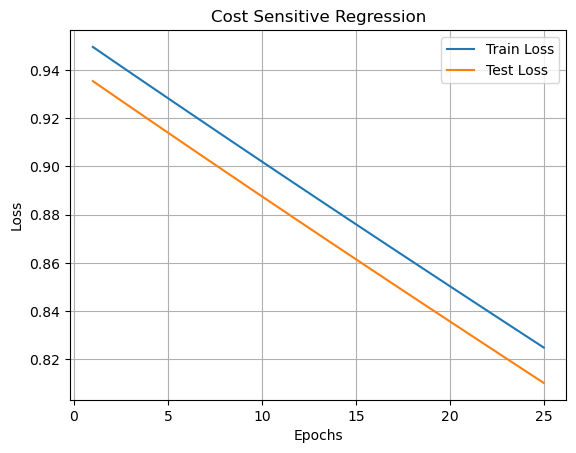

In [299]:
epochs = 25
tp = 4
fp = 4
tn = 0
train_losses = []
test_losses = []
model = CostSensitiveRegression(12 , 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = CostSensitiveLoss(Y_train, y_hat_probs, TP_train, FP_train, FN_train, TN_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # testing loss
    y_hat_probs_test = model(X_test)
    Y_hat_test = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_probs_test], dtype=torch.float32)
    loss_test = CostSensitiveLoss(Y_test, y_hat_probs_test, TP_test, FP_test, FN_test, TN_test)
    test_losses.append(loss_test.item())

    print(f'Epoch {epoch+1}/{epochs} : Train Loss = {loss.item():.4f} , Test Loss = {loss_test.item():.4f}')

ticks = [i for i in range(1, epochs+1)]
plt.title('Cost Sensitive Regression')
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [300]:
y_hat = model(X_test)
Y_hat = torch.tensor([1 if i > 0.5 else 0 for i in y_hat], dtype=torch.float32).reshape(-1,1)
print("Accuracy is {}".format((Y_hat == Y_test).sum().item()/len(Y_test) * 100))

Accuracy is 85.76605256028176
